In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fontstyle/NanumBarunGothic.ttf
/kaggle/input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/testData.tsv
/kaggle/input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv
/kaggle/input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/sampleSubmission.csv
/kaggle/input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/unlabeledTrainData.tsv


## Train 데이터의 텍스트를 바탕으로 Test 데이터의 Sentiment을 예측
### 0이면 부정, 1이면 긍정

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
plt.rcParams["axes.unicode_minus"] = False
fontpath ="../input/fontstyle/NanumBarunGothic.ttf"
fontprop = font_manager.FontProperties(fname = fontpath)

In [4]:
# header = 0 : 파일의 첫 번째 줄에 열 이름이 있음을 나타낸다.
# delimiter = "\t" : \t는 필드가 tab으로 구분되는 것을 의미한다.
# quoting = 3 : 3은 텍스트의 쌍따옴표를 무시하도록 한다.


df_train = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv",
                       header = 0, delimiter = "\t", quoting = 3)

df_test = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/testData.tsv",
                     header = 0, delimiter = "\t", quoting = 3)
 
df_train.shape

(25000, 3)

In [5]:
df_train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
df_test.shape

(25000, 2)

In [7]:
df_test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [8]:
print("Train Columns: ")
print(df_train.columns.values)
print("--------------------------------")
print("Test Columns: ")
print(df_test.columns.values)

# Test 데이터 셋에 없는 Sentiment를 예측한다.

Train Columns: 
['id' 'sentiment' 'review']
--------------------------------
Test Columns: 
['id' 'review']


In [9]:
# null value는 없음.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [10]:
# sentiment의 통계값 확인
df_train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [11]:
# sentiment의 클래스가 절반으로 나뉘어 있음을 알 수 있다. (부정, 긍정)
df_train["sentiment"].value_counts()

0    12500
1    12500
Name: sentiment, dtype: int64

In [12]:
# review 컬럼을 100-자 까지만 확인해본다.

df_train["review"][0][:1000]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

### 데이터 정제 Data Cleaning and Text Preprocessing

- 기계가 텍스트를 이해할 수 있도록 텍스트를 정제해준다.
- 신호와 소음을 구분한다. 아웃라이어 데이터로 인한 오버피팅을 방지한다.
1. BeatifulSoup을 통해 HTML 태그를 제거
2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
3. NLTK 데이터를 사용해 불용어 제거
4. 어간추출(Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 어간을 추출

### 텍스트 데이터 전처리 이해하기

#### 정규화 normalization

In [13]:
!pip install BeautifulSoup4

In [14]:
from bs4 import BeautifulSoup

exam1 = BeautifulSoup(df_train["review"][0], "html5lib")
print(df_train["review"][0][:1000])
exam1.get_text()[:1000]

# BeautifulSoup을 불러와서 review를 확인하다.
# 그냥 print 한것과 exam으로 불러온 텍스트를 비교해보면
# <br \>과 같은 html 태그들이 사라진 것을 볼 수 있다.

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

In [15]:
import re

letters_only = re.sub("[^a-zA-Z]", " ", exam1.get_text())
letters_only[:1000]

# re를 불러와서 정규표현식으로 특수문자를 제거한다.
# 소문자와 대문자가 아닌 것은 공백으로 대체한다. (re.sub("바꿔야 할 것", "바꾸고 싶은 것"))
# output을 보면 특수문자들이 전부 공백으로 대체된 것을 볼 수 있다

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    m

In [16]:
lower_case = letters_only.lower()

words = lower_case.split()
print(len(words))
words[:10]

# letters_only를 전부 소문자로 대체해준다,.
# split을 사용하여 단어 단위로 나눈다. (토큰화)
# 437개의 토큰으로 이루어져 있다.

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

### 불용어 제거 (Stopword Removal)
- 일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세서에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다.
- 예를 들어 조사, 접미사, i, me, it, this, that, is, are 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다.
- Stopwords는 "to" 또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다.
- NLTK에는 153개의 영어 불용어가 미리 정의되어 있다.
- 17개의 언어에 대해 정이되어 있으며 한국어는 없다.


In [17]:
import nltk
from nltk.corpus import stopwords
stopwords.words("english")[:10]

# NLTK를 불러오고, stopwords까지 불러와서 확인해본다.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [18]:
words = [w for w in words if not w in stopwords.words("english")]
print(len(words))
words[:10]

# words에 담겨져 있던 단어에 Stopwords가 있다면 제거한다.
# 제거한 토큰들을 확인한다.
# 토큰이 437개에서 219개로 줄어들었음을 알 수 있다.

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

### 스테밍(어간추출, 형태소 분석)
- 어간 추출은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해내는 것
- "message", "messages", "messsaging"과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
- stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 여러가지 stemmer들이 있는데, 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 조금 더 적극적이다.
- 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다.

In [19]:
# 포터 스태머의 사용 예시

stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem("maximum"))
print("The stemmed form of running is : {}".format(stemmer.stem("running")))
print("The stemmed form of runs is : {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

# maximum이 그대로 출력된다.
# run의 변형어들은 run으로 어간이 추출된다.

maximum
The stemmed form of running is : run
The stemmed form of runs is : run
The stemmed form of run is: run


In [20]:
# 랭커스터 스태머의 사용 예시

from nltk.stem.lancaster import LancasterStemmer

lanc_stemmer = LancasterStemmer()
print(lanc_stemmer.stem("maximum"))
print("The stemmed form of running is : {}".format(lanc_stemmer.stem("running")))
print("The stemmed form of runs is : {}".format(lanc_stemmer.stem("runs")))
print("The stemmed form of run is : {}".format(lanc_stemmer.stem("run")))

# maximum의 어간이 maxim으로 추출된다.
# run의 변형어들은 마찬가지로 rund으로 어간이 추출된다.

maxim
The stemmed form of running is : run
The stemmed form of runs is : run
The stemmed form of run is : run


In [21]:
words[:10]

# 처리하기 전 단어들을 확인해본다.
# going, started, listening 등 변형된 단어가 있음을 알 수 있다.

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [22]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
words = [stemmer.stem(w) for w in words]

words[:10]

# goring, started, listening 등의 어간이 잘 추출된 것을 확인할 수 있다.

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### Lemmatization (음소표기법)

언어학에서 음소표기법은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절된 형태의 단어을 그룹화하는 과정이다. 예를 들어 동이의어가 문맥에 따라 다른 의미를 갖는데,
1. 배가 맛있다.
2. 배를 타는 것이 재미있다.
3. 평소보다 두 배로 많이 먹어서 배가 아프다.

위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다.

Lemmatization은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.

영어에서 meet는 meeting으로 쓰였을 때 회의를 뜻하지만 meet일 때는 만나다라는 뜻을 갖는데, 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.

In [23]:
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()

print(wordnet_lem.lemmatize("fly"))
print(wordnet_lem.lemmatize("flies"))

words = [wordnet_lem.lemmatize(w) for w in words]

words[:10]

# lemmatizer를 사용하여 fly, flies를 처리하면 둘 다 fly로 바뀐다.
# words를 lemmatization 처리한 후 결과를 확인해본다.
# stemming한 결과와 마찬가지로 출력된다.

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### 문자열 처리

In [24]:
def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review, "html.parser").get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    return(" ".join(stemming_words))

# 1. def로 함수 선언
# 2. HTML 제거
# 3. 영문자가 아닌 문자는 공백으로 변환한다.
# 4. 소문자로 변환하고 split을 사용하여 단어 단위로 나눈다.
# 5. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다. stopwords를 세트로 변환
# 6. Stopwords 불용어 제거
# 7. Stemming으로 어간 추출
# 8. 공백으로 구분된 문자열로 결합하여 결과 반환


In [25]:
clean_review = review_to_words(df_train["review"][0])
clean_review

# review 데이터의 첫 번째 데이터를 함수에 넣고 실행해본다.
# review 문장들이 토큰화되어 깔끔하게 처리되었음을 확인한다.

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [26]:
num_reviews = df_train["review"].size
num_reviews

25000

In [27]:
# 적용시간이 오래걸리는 문제로 인해 multiprocessing을 사용하여 함수에 적용시켜준다.
# multiprocessing을 사용하면 복잡하고 오래걸리는 작업을 별도의 프로세스를 생성 후
# 병렬 처리해서 보다 빠른 응답속도를 기대할 수 있는 장점이 있다.

from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라미터를 꺼냄
    workers = kwargs.pop("workers")
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes = workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠서 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
                                 for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))
    

In [28]:
%time clean_train_reviews = apply_by_multiprocessing(df_train["review"], review_to_words, workers = 4)

CPU times: user 82.5 ms, sys: 121 ms, total: 203 ms
Wall time: 52.6 s


In [29]:
%time clean_test_reviews = apply_by_multiprocessing(df_test["review"],review_to_words, workers = 4)

CPU times: user 88.7 ms, sys: 112 ms, total: 201 ms
Wall time: 52.2 s


### 워드 클라우드
- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data = None, background_color = "black", width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color = background_color,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

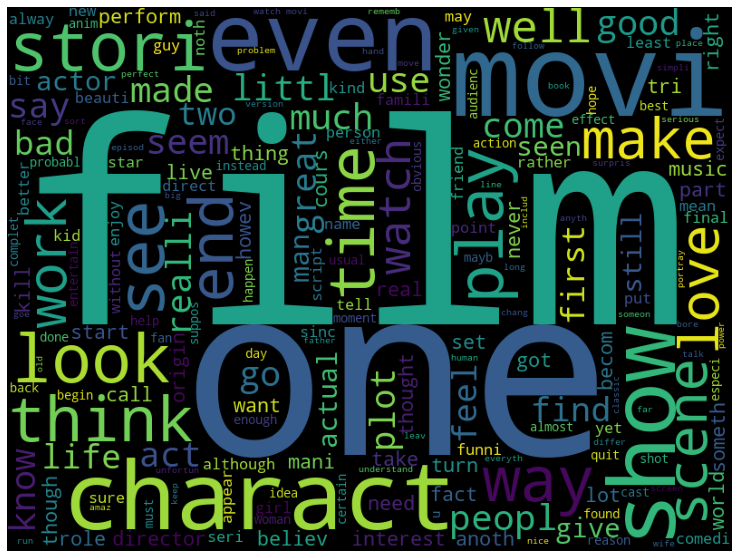

In [33]:
displayWordCloud(" ".join(clean_train_reviews))

In [36]:
# set 자료형은 문자열의 경우에는 해당 문자열을 낱개로 쪼개어 각각의 문자들을 하나의 인자로 인식하여 집합을 만든다
df_train["num_words"] = clean_train_reviews.apply(lambda x : len(str(x).split()))
df_train["num_uniq_words"] = clean_train_reviews.apply(lambda x : len(set(str(x).split())))

# 단어 개수 컬럼 생성
# 중복을 제거한 unique 단어 개수 컬럼 생성

In [43]:
x = clean_train_reviews[0]
x = set(str(x).split())
print(len(x))

156


In [44]:
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

# 첫 번째 리뷰의 단어를 세어보면 219개이다.

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값:  119.52356
리뷰별 단어 중간 값:  89.0
리뷰별 고유 단어 평균 값:  94.05756
리뷰별 고유 단어 중간 값:  74.0


Text(0.5, 1.0, '리뷰별 고유 단어 수 분포')

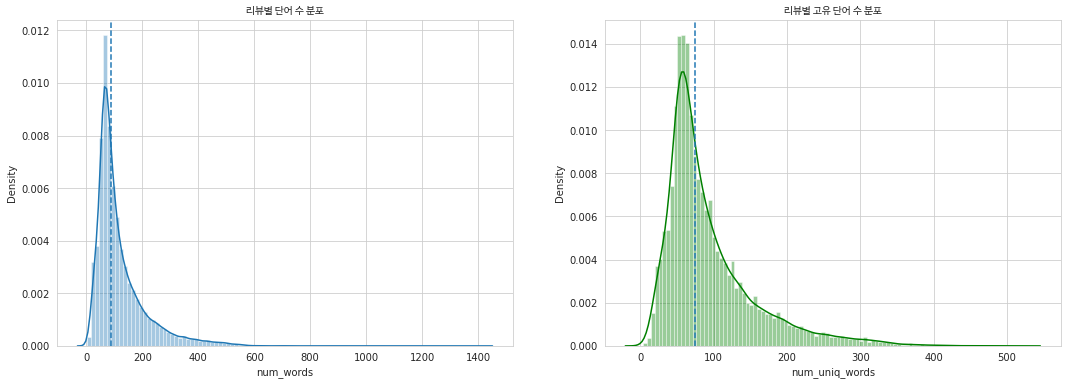

In [47]:
import seaborn as sns

fig, ax = plt.subplots(ncols = 2, figsize = (18, 6))
print("리뷰별 단어 평균 값: ", df_train["num_words"].mean())
print("리뷰별 단어 중간 값: ", df_train["num_words"].median())
sns.distplot(df_train["num_words"], bins = 100, ax = ax[0])
ax[0].axvline(df_train["num_words"].median(), linestyle = "dashed")
ax[0].set_title("리뷰별 단어 수 분포", fontproperties = fontprop)

print("리뷰별 고유 단어 평균 값: ", df_train["num_uniq_words"].mean())
print("리뷰별 고유 단어 중간 값: ", df_train["num_uniq_words"].median())
sns.distplot(df_train["num_uniq_words"], bins = 100, color = "g", ax=ax[1])
ax[1].axvline(df_train["num_uniq_words"].median(), linestyle = "dashed")
ax[1].set_title("리뷰별 고유 단어 수 분포", fontproperties = fontprop)

### Bag-of-words model

### 텍스트 데이터 벡터화

다음의 두 문장이 있다고 하자,

1.John likes to watch movies. Mary likes movies too.
2.John also likes to watch football games.

위 두 문장을 토큰화하여 가방에 담아주면 다음과 같다.

[ "John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games" ]

그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.
(1) [1,2,1,1,2,1,1,0,0,0] (2) [1,1,1,1,0,0,0,1,1,1]

=> 머신러닝 알고리즘이 이해할 수 있는 형태로 바꿔주는 작업이다.
단어 가방을 n-gram을 사용해 bigram으로 담아주면 다음과 같다.
[ "John likes", "likes to", "to watch", "watch movies", "Mary likes", "likes movies", "movies too" ]

=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.

### Sklearn의 CountVectorizer를 통해 피처 생성
- 정규표현식을 사용해 토큰을 추출한다.
- 모두 소문자로 변환시키기 때문에 good, Good, gOOd이 모두 같은 특성이 된다.
- 의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
- min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다


In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = "word",
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            min_df = 2, # 토큰이 나타날 최소 문서 개수
                            ngram_range = (1, 3), # 유니그램, 바이그램 등
                            max_features = 20000 # 최대 피쳐의 개수
                            )

vectorizer



CountVectorizer(max_features=20000, min_df=2, ngram_range=(1, 3))

In [52]:
# 속도 개선을 위해 파이프라인을 사용하도록 개선

pipeline = Pipeline([
    ("vect", vectorizer),
]) 

In [53]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)

train_data_features

CPU times: user 28.4 s, sys: 975 ms, total: 29.3 s
Wall time: 29.4 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [54]:
train_data_features.shape

# 25000의 관측치와 위에서 지정해주었던 20000개의 feature로 이루어져 있음.

(25000, 20000)

In [56]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

# feature의 이름 (단어)를 확인

20000


['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [59]:
dist = np.sum(train_data_features, axis =0 )

for tag, count in zip(vocab, dist):
    print(count, tag)

pd.DataFrame(dist, columns = vocab)

# 단어를 count 해줘서 한번에 확인

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [62]:
pd.DataFrame(train_data_features[:10].toarray(), columns = vocab).head()

# 각각의 row가 어떤 단어를 포함하고 있는지 확인하기 위함

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### RandomForest로 예측해보기

In [63]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)

model

RandomForestClassifier(n_jobs=1, random_state=42)

In [64]:
%time model = model.fit(train_data_features, df_train["sentiment"])

CPU times: user 54.5 s, sys: 25.9 ms, total: 54.6 s
Wall time: 54.6 s


In [65]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
                                     model, train_data_features, \
                                     df_train["sentiment"], cv = 10,\
                                     scoring = "roc_auc"))

CPU times: user 7min 34s, sys: 245 ms, total: 7min 34s
Wall time: 7min 35s


In [66]:
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [67]:
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# test 데이터도 똑같이 파이프라인을 사용하여 벡터화 시켜준다,

CPU times: user 7.98 s, sys: 2.04 ms, total: 7.99 s
Wall time: 7.99 s


In [68]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
# 벡터화하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
vocab = vectorizer.get_feature_names()
vocab[8], vocab[1300], vocab[10000], vocab[12000]

('abc', 'basic movi', 'los angel', 'never bore')

In [72]:
y_pred = model.predict(test_data_features)
y_pred[:10]

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [74]:
sub = pd.DataFrame(data = {"id":df_test["id"], "sentiment": y_pred})
sub.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1


In [75]:
sub.to_csv("./tutorial_1_LB{:.5f}.csv".format(score), index = False, quoting = 3)

In [76]:
sub_sent = sub["sentiment"].value_counts()
print(sub_sent[0] - sub_sent[1])
sub_sent

# submission의 부정과 긍정의 차이를 살펴본다.

44


0    12522
1    12478
Name: sentiment, dtype: int64